In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

OPENAI_API_BASE = os.environ.get("OPENAI_API_BASE")
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

LANGCHAIN_TRACING_V2 = os.environ.get("LANGCHAIN_TRACING_V2")
LANGCHAIN_ENDPOINT = 'https://api.smith.langchain.com'
LANGCHAIN_API_KEY = os.environ.get("LANGCHAIN_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="qwen-max", temperature=0)

# Simple Graph

![simple_graph](https://raw.githubusercontent.com/realyinchen/RAG/refs/heads/main/imgs/simple_graph.png)

### State

In [3]:
from typing import TypedDict

class State(TypedDict):
    graph_state: str

### Nodes

In [4]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

### Edges

In [5]:
import random
from typing import Literal

def decide_nood(state) -> Literal['node_2', 'node_3']:
     # Often, we will use state to decide on the next node to visit
     # user_input = state['graph_state']

     # Here, let's just do a 50 / 50 split between nodes 2, 3
     if random.random() < 0.5:
          # 50% of the time, we return Node 2
          return 'node_2'
     # 50% of the time, we return Node 3
     return 'node_3'

### Graph Construction

In [6]:
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(state_schema=State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_nood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

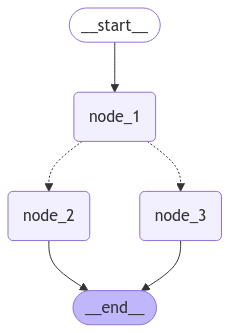

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Graph Invocation

In [8]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

---Node 1---
---Node 3---


{'graph_state': 'Hi, this is Lance. I am sad!'}

# Chain

![chain](https://raw.githubusercontent.com/realyinchen/RAG/refs/heads/main/imgs/chain.png)

### State

In [9]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

### Tools

In [10]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

### Graph Construction

In [11]:
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build Graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

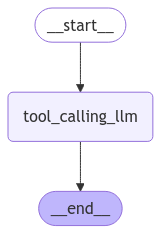

In [12]:
display(Image(graph.get_graph().draw_mermaid_png()))

### Graph Invocation

In [13]:
from langchain_core.messages import HumanMessage

messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


In [14]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_af205de093e849359f62d8)
 Call ID: call_af205de093e849359f62d8
  Args:
    a: 2
    b: 3


# Router

![router](https://github.com/realyinchen/RAG/blob/main/imgs/router.png?raw=true)

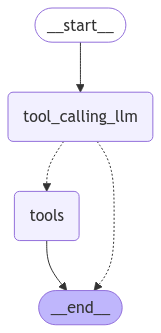

In [16]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
messages = [HumanMessage(content="Hello, what is 2 multiplied by 2? .")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what is 2 multiplied by 2? .
================================== Ai Message ==================================
Tool Calls:
  multiply (call_793642d0c35f43c1a6e3f2)
 Call ID: call_793642d0c35f43c1a6e3f2
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4


In [18]:
messages = [HumanMessage(content="Hello, world!")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, world!
================================== Ai Message ==================================

Hello! How can I assist you today?


# Agent

![agent](https://github.com/realyinchen/RAG/blob/main/imgs/agent.png?raw=true)

### Tools

In [19]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, 
# and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, 
# see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

### Graph Construction

In [20]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [22]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

react_graph = builder.compile()

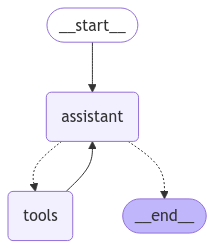

In [23]:
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

### Graph Invocation

In [24]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [25]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_38898d4dea5c414aa82c5f)
 Call ID: call_38898d4dea5c414aa82c5f
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_3a1833f5e2304e5f87294a)
 Call ID: call_3a1833f5e2304e5f87294a
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_9060ddc8505f415fac7f99)
 Call ID: call_9060ddc8505f415fac7f99
  Args:
    a: 14
    b: 5
================================= Tool Message ===========================

# Agent Memory

In [26]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

In [27]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_6461f27649774f9b857a63)
 Call ID: call_6461f27649774f9b857a63
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [28]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_6461f27649774f9b857a63)
 Call ID: call_6461f27649774f9b857a63
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_60eaf7328a8a4a16b07c68)
 Call ID: call_60eaf7328a8a4a16b07c68
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multiplying 7 b